#### Package requirements:
```python
numpy
skimage
scipy
matplotlib
PIL
```

In [1]:
import sys
sys.path.append("/usr/local/lib/python2.7/site-packages/")

In [72]:
import numpy as np
import cv2
from skimage.feature import canny, peak_local_max, hog
from skimage.color import rgb2gray
from skimage.morphology import dilation, erosion, watershed, reconstruction, square, disk, skeletonize
from skimage.transform import (resize, rotate, hough_circle, 
                               hough_circle_peaks, hough_line, hough_line_peaks, 
                               probabilistic_hough_line)
from skimage.filters import sobel, gaussian, roberts, scharr, prewitt
from skimage.draw import circle_perimeter, polygon
from skimage.util import img_as_ubyte, img_as_uint, invert, crop
from skimage import color

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from scipy import ndimage as ndi
from scipy.misc import imresize
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
def edge_filter(img_gray, filter_func=sobel):
    edge = canny(filter_func(img_gray), sigma=0.2, low_threshold=0.85, 
                 high_threshold=0.95, use_quantiles=True)
    edge = ndi.binary_closing(edge)
    return edge

In [5]:
def load_boundary_idx(gray_img):
    obj_idx = np.where(gray_img > 0.)
    return (np.min(obj_idx[0]), np.max(obj_idx[0]), 
            np.min(obj_idx[1]), np.max(obj_idx[1]))

In [6]:
def remove_small_obj(segmentation, cut_threshold=0.05):
    n_pixels = np.product(segmentation.shape)
    threshold = int(n_pixels * cut_threshold)
    unique_objects = np.delete(np.unique(segmentation), 0)
    for obj in unique_objects:
        seg_length = len(np.where(segmentation == obj)[0])
        if seg_length < threshold:
            segmentation[segmentation==obj] = 0
    unique_objects = np.delete(np.unique(segmentation), 0)
    return unique_objects

In [62]:
def hough_line_transform(image):
    h, theta, d = hough_line(image)
    # Plot the transformed hough lines
    _, angle, dist = hough_line_peaks(h, theta, d, num_peaks=1)
    angle_deg = np.rad2deg(angle[0])
    if angle_deg < 0:
        angle_deg += 180.
    return angle_deg

In [8]:
def probabilistic_hough_line_transform(image):
    edge = canny(image, sigma=2.5)
    plt.imshow(edge)
    plt.show()
    lines = probabilistic_hough_line(edge, threshold=5, line_length=5, line_gap=5)
    plt.imshow(image)
    for line in lines:
        p0, p1 = line
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
    plt.show()

In [64]:
def hough_circle_transform(image, edges, show_fig=False):
    max_edge = max(image.shape)
    min_bound = int(max_edge / float(6) - 40)
    max_bound = int(max_edge / float(6) + 80)
    
    hough_radii = np.arange(min_bound, max_bound, 5)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1, num_peaks=1)
    
    print accums, radii

    # Draw them
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = image * 0
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        image[circy, circx] = 1
    image = ndi.binary_fill_holes(image)
    print "Hough circle transform"
    if show_fig:
        plt.imshow(image)
        plt.show()
    
    return image

In [10]:
def exclude_circle(gauge_face, circle_img):
    gauge_face[circle_img == False] = False
    gauge_face[np.logical_or(gauge_face, circle_img)] = True
    return gauge_face

#### Load the example data and visualization

In [63]:
# Load the RGB image and convert it to Grayscale
def gauge_segmentation(index, show_fig = False):
    data = ndi.imread("data/sample_{0}.jpg".format(index))
    data_gray = rgb2gray(data)

    # Visualize data
    if show_fig:
        fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
        axarr[0].imshow(data)
        axarr[0].axis('off')
        axarr[0].set_title("RGB image")
        axarr[1].imshow(data_gray, cmap='gray')
        axarr[1].axis('off')
        axarr[1].set_title("Grayscale image")
        plt.show()

    # Apply canny edge detector, may need to adjust sigma for performance
    # sigma is sensitive to the edge color of the gauge
    # e.g: silver colored edge needs a low sigma color to detect
    data_edge = edge_filter(data_gray, filter_func=sobel)

    # Close the holes from canny detector
    segmentation = ndi.binary_fill_holes(data_edge)

    # Label these segments
    segmentation_labeled, n_classes = ndi.label(segmentation)

    # Count number of pixels for each segment
    sizes = np.bincount(segmentation_labeled.ravel())

    # Filter out small objects whose pixel numbers are smaller than 
    # 10% of the entire image
    sum_pixels = data_edge.shape[0] * data_edge.shape[1]
    mask_sizes = sizes > (0.05 * sum_pixels)
    mask_sizes[0] = 0
    gauge_face = mask_sizes[segmentation_labeled]
    
    gauge_face_edge = canny(gauge_face, sigma=0.2, low_threshold=0.85, high_threshold=0.95, use_quantiles=True)
    circle_image = hough_circle_transform(data_gray, gauge_face_edge, show_fig=show_fig)
    
    # For the gauge face segmentation, the gauge face that not in the 
    gauge_face_excluded = exclude_circle(gauge_face, circle_image)

    # Calculate the distance of object pixel to closest background pixel
    distance = ndi.distance_transform_edt(gauge_face)

    # Find the local maxima on the image, num_peaks could be 
    # adjustable values depending on how circles on the image
    peak_local_maxima = peak_local_max(distance, indices=False, num_peaks=2, min_distance=20)
    markers = ndi.label(peak_local_maxima)[0]

    # Segement the overlapped objects using watershed algorithm
    overlap_segmentation = watershed(-distance, markers, mask = gauge_face)
    segments = remove_small_obj(overlap_segmentation)
    
    if show_fig:
        fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
        axarr[0, 0].imshow(data_edge)
        axarr[0, 0].axis('off')
        axarr[0, 0].set_title('Edge Detection of Grayscale Image')
        axarr[0, 1].imshow(segmentation)
        axarr[0, 1].axis('off')
        axarr[0, 1].set_title('Filled Image')
        axarr[1, 0].imshow(segmentation_labeled)
        axarr[1, 0].axis('off')
        axarr[1, 0].set_title('Labeled Segments')
        axarr[1, 1].imshow(gauge_face)
        axarr[1, 1].axis('off')
        axarr[1, 1].set_title('Gauge Surface Only')
        axarr[2, 0].imshow(distance)
        axarr[2, 0].axis('off')
        axarr[2, 0].set_title('Distance to Background')
        axarr[2, 1].imshow(dilation(markers, np.ones((20, 20))))
        axarr[2, 1].axis('off')
        axarr[2, 1].set_title('Marked Segment Centers')
        axarr[3, 0].imshow(overlap_segmentation)
        axarr[3, 0].axis('off')
        axarr[3, 0].set_title('Segments')
        axarr[3, 1].axis('off')
        plt.show()
    
    return data_gray, overlap_segmentation, segments

In [12]:
def clip_circled_area(data_gray, segmentation, object_id, show_fig=False):
    segmentation[segmentation != object_id] = 0
    y_lb, y_ub, x_lb, x_ub = load_boundary_idx(segmentation)
    
    max_seg = np.max(segmentation)
    
    # clipped both data and segmentation
    clipped_segmentation = (imresize(segmentation[y_lb:y_ub+1, x_lb:x_ub+1], (300, 300), interp='nearest') / 
                            (255. / max_seg))
    clipped_data_gray = imresize(data_gray.copy()[y_lb:y_ub+1, x_lb:x_ub+1], (300, 300), interp='nearest')
    
    
    # masking the area with the correct segmentation
    clipped_data_gray[clipped_segmentation!=object_id] = 0
    
    if show_fig:
        plt.imshow(clipped_data_gray)
        plt.show()
    
    gauge = clipped_data_gray.copy()
    
    # return
    return img_as_ubyte(gauge)

In [13]:
def parse_hulls(hulls):
    res_hulls = []
    for hull in hulls:
        nodes = np.zeros((len(hull), 2))
        for i, node in enumerate(hull):
            nodes[i, 0] = node[0, 0]
            nodes[i, 1] = node[0, 1]
        nodes = np.vstack((nodes, nodes[0]))
        res_hulls.append(nodes)
    return res_hulls

In [14]:
def opencv_mser(img_gray, detect="pointer"):
    pix_size = np.product(img_gray.shape)
    if detect=="pointer":
        min_thres = 0.01 * pix_size
        max_thres = 0.05 * pix_size
    else:
        min_thres = 100
        max_thres = 500
    print min_thres
    print max_thres
    vis = img_gray.copy()
    mser = cv2.MSER(15, int(min_thres), int(max_thres), 1)
    regions = mser.detect(img_gray, None)
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
    res_hulls = parse_hulls(hulls)
    return res_hulls

In [15]:
def visualize_hulls(img_gray, hulls):
    plt.imshow(img_gray)
    for hull in hulls:
        plt.plot(hull[:, 0], hull[:, 1], '-k')
    plt.show()

In [16]:
def visualize_regions(img_gray, regions):
    plt.imshow(img_gray)
    for region in regions:
        plt.imshow(region, alpha=0.1)
    plt.show()

In [17]:
def hulls_to_regions(img_gray, hulls):
    regions = []
    for hull in hulls:
        white_img = img_gray * 0
        r, c = hull[:, 1], hull[:, 0]
        rr, cc = polygon(r, c, shape = img_gray.shape)
        white_img[rr, cc] = 1
        regions.append(white_img)
    return regions

In [18]:
def remove_noncentral_hulls(img_gray, hulls):
    filtered_hulls = []
    img_gray_center = (img_gray.shape[1] / 2., img_gray.shape[0] / 2.)
    for hull in hulls:
        hull_center = (np.nanmean(hull[:, 0]), np.nanmean(hull[:, 1]))
        if hull_center[0] < (img_gray_center[0] + 50) and hull_center[0] > (img_gray_center[0] - 50):
            if hull_center[1] < (img_gray_center[1] + 50) and hull_center[1] > (img_gray_center[1] - 50):
                filtered_hulls.append(hull)
    return filtered_hulls

In [19]:
def skeletonize_pointer(img_gray, binarized_regions):
    skeletons = []
    for region_binary in binarized_regions:
        region_skeleton = skeletonize(region_binary)
        skeletons.append(region_skeleton)
    return skeletons

In [20]:
def binarize_regions(img_gray, regions):
    binarized_regions = []
    for region in regions:
        region_gray = img_gray.copy()
        region_gray[region == 0] = 0
        region_mean = np.mean(region_gray[region != 0])
        region_binary = region_gray < region_mean
        region_binary[region == 0] = False
        binarized_regions.append(region_binary)
    return binarized_regions

In [21]:
def regions_binary_histogram(regions_binary, angle=0):
    y_idx = None
    x_idx = None
    for region_binary in regions_binary:
        region_binary = rotate(region_binary, angle=angle)
        index = np.where(region_binary==True)
        if y_idx is None:
            y_idx = index[0]
            x_idx = index[1]
        else:
            y_idx = np.append(y_idx, index[0])
            x_idx = np.append(x_idx, index[1])
    y_hist, y_bins = np.histogram(y_idx, bins=10, normed=True)
    x_hist, x_bins = np.histogram(x_idx, bins=10, normed=True)    
    return y_hist, x_hist

In [69]:
def pointer_angles(binarized_regions, angle=0, show_fig=False):
    pointer_angles = []
#     plt.imshow(rotate(binarized_regions[0], angle=angle))
#     plt.show()
    for region in binarized_regions:
        est_angle = hough_line_transform(rotate(region, angle=angle))
        pointer_angles.append(est_angle)
    angle_mean = np.mean(pointer_angles)
    angle_std = np.std(pointer_angles)
    if angle_std > 10:
        angle_mean = pointer_angles[0]
    if show_fig:
        plt.imshow(binarized_regions[0])
        (y_len, x_len) = binarized_regions[0].shape
        delta = x_len / 2. * np.tan(np.deg2rad(90. - angle_mean))
        plt.plot([0, x_len], [y_len / 2. + delta, y_len / 2. - delta], '-r')
        plt.xlim([0, x_len])
        plt.ylim([y_len, 0])
        plt.show()
    return angle_mean

In [23]:
def train_classifier(training_features, classes):
    clf = RandomForestClassifier(min_samples_leaf=5, max_depth=5)
    clf.fit(training_features, classes)
    return clf

In [60]:
def train_quandrant_classifier(binarized_regions):
    y_hist_train = np.zeros((len(np.arange(45, -315, -1)), 10))
    y_hist_classes = np.zeros(len(np.arange(45, -315, -1)))
    x_hist_train = y_hist_train.copy()
    x_hist_classes = np.zeros(len(np.arange(45, -315, -1)))
    for i, angle in enumerate(np.arange(45, -315, -1)):
        y_hist, x_hist = regions_binary_histogram(binarized_regions, angle=angle)
        y_hist_train[i] = y_hist
        x_hist_train[i] = x_hist
        if angle <= 45 and angle > -135:
            x_hist_classes[i] = 1
        else:
            x_hist_classes[i] = 0
        if (angle <= 45 and angle > -45) or (angle <= -225 and angle > -315):
            y_hist_classes[i] = 1
        else:
            y_hist_classes[i] = 0
    clf_y_vertical = train_classifier(y_hist_train, y_hist_classes)
    clf_x_horizontal = train_classifier(x_hist_train, x_hist_classes)
    return clf_y_vertical, clf_x_horizontal

In [52]:
def quadrant_predict(binarized_regions, y_classifier, x_classifier, angle=0):
    y_hist, x_hist = regions_binary_histogram(binarized_regions, angle=angle)
    y_class = y_classifier.predict(y_hist[:, np.newaxis].T)
    x_class = x_classifier.predict(x_hist[:, np.newaxis].T)
    return y_class[0], x_class[0]

In [32]:
def angle_decision(angle, y_class, x_class):
    # y_class: [1, 0] = [Down, Up]
    # x_class: [1, 0] = [Left, Right]
    res_angle = angle
    if y_class == 0 and x_class == 0:
        if angle <= 110:
            res_angle += 180
    if y_class == 1 and x_class == 0:
        if angle >= 70:
            res_angle += 180
    if y_class == 1 and angle > 135:
        res_angle += 180
    if y_class == 0 and angle < 45:
        res_angle += 180
    if res_angle > 360:
        res_angle -= 180
    return res_angle

In [76]:
def ocr(img_gray, quadrant=1):
    (y_len, x_len) = img_gray.shape
    if quadrant == 1:
        y_range = [int(y_len / 2), y_len]
        x_range = [0, int(x_len / 2)]
    elif quadrant == 2:
        y_range = [0, int(y_len / 2)]
        x_range = [0, int(x_len / 2)]
    elif quadrant == 3:
        y_range = [0, int(y_len / 2)]
        x_range = [int(x_len / 2), x_len]
    elif quadrant == 4:
        y_range = [int(y_len / 2), y_len]
        x_range = [int(x_len / 2), x_len]
    else:
        raise ValueError("The quadrant # is not valid")
    img_quadrant = img_gray[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    opencv_mser(img_quadrant, )
    plt.imshow(img_quadrant)
    plt.show()

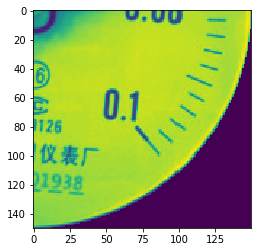

In [77]:
ocr(gauge, quadrant=4)

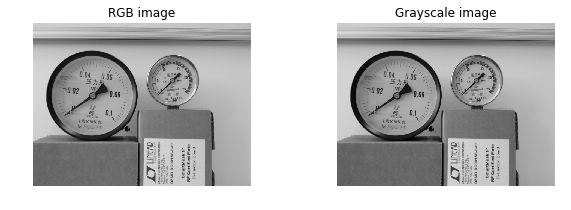

[ 0.4] [148]
Hough circle transform


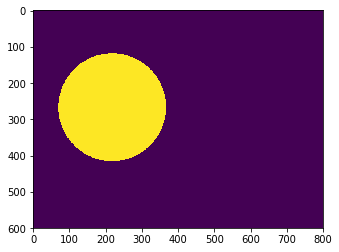

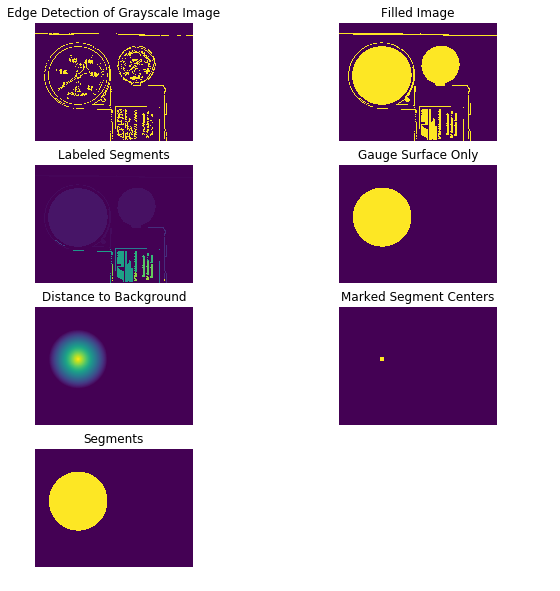

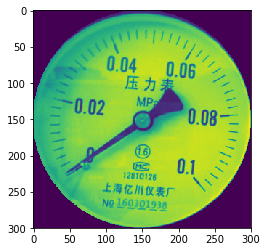

900.0
4500.0


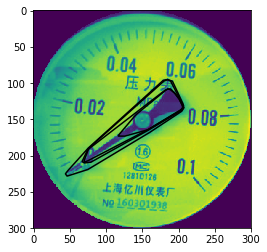

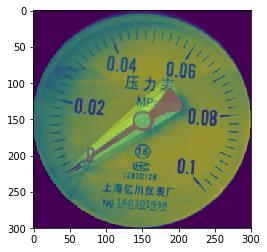

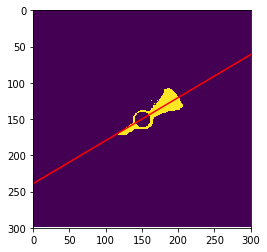

59.3296089385


In [70]:
data_gray, segmentation_img, valid_segments = gauge_segmentation(5, show_fig=True)
gauge = clip_circled_area(data_gray, segmentation_img, valid_segments[0], show_fig=True)
hulls = opencv_mser(gauge)
filtered_hulls = remove_noncentral_hulls(gauge, hulls)
visualize_hulls(gauge, filtered_hulls)
regions = hulls_to_regions(gauge, filtered_hulls)
visualize_regions(gauge, regions)
binarized_regions = binarize_regions(gauge, regions)
skeletons = skeletonize_pointer(gauge, regions)

angle_prior = pointer_angles(binarized_regions, angle=0, show_fig=True)
y_class, x_class = quadrant_predict(binarized_regions, clf_y_vertical, clf_x_horizontal, angle=0)
angle_posterior = angle_decision(angle_prior, y_class, x_class)
print angle_posterior
# regions_binary_histogram(binarized_regions)

#### Image processing and segmentation
The pipeline is as follows:
* Canny Edge Detection
* Fill holes using the edge image
* First round of segmentation, segmenting 5 meters
* Second round of segmentation, because these 5 meters are overlapped we should segment them again

#### Training Data Auto Generation

In [107]:
def separate_arrow_scale(data_gray, segmentation, object_id):
    temp_data_gray = np.copy(data_gray)
    temp_data_gray[segmentation != object_id] = 0

    # Get the indices bound of the object from the original image
    y_lb, y_ub, x_lb, x_ub = load_boundary_idx(temp_data_gray)

    # Zoom into the object and standardize the shape 
    # (standardization is important for machine learning)
    zoom_temp_data_gray = resize(temp_data_gray[y_lb:y_ub+1, x_lb:x_ub+1], 
                                 (120, 120))
    
    zoom_temp_segmentation = resize(segmentation[y_lb:y_ub+1, x_lb:x_ub+1],
                                    (120, 120), order=0)
    
    thres = (np.mean(zoom_temp_segmentation.flatten()) - 
             np.std(zoom_temp_segmentation.flatten()))
    
    zoom_temp_segmentation[zoom_temp_segmentation > thres] = 1
    zoom_temp_segmentation[zoom_temp_segmentation <= thres] = 0
    
    plt.imshow(zoom_temp_segmentation)
    plt.colorbar()
    plt.show()
    
    zoom_temp_segmentation_eroded = erosion(zoom_temp_segmentation, selem=disk(20))
    
    # plot the eroded segmented area
    plt.imshow(zoom_temp_segmentation_eroded)
    plt.colorbar()
    plt.show()
    
    zoom_temp_data_gray[zoom_temp_segmentation_eroded==0] = 0
    
    # Probablistic hough line transformation
    probablistic_hough_line_transform(zoom_temp_data_gray)
    
    zoom_temp_data_gray_flat = zoom_temp_data_gray.flatten()
    zoom_temp_data_gray_flat = zoom_temp_data_gray_flat[zoom_temp_data_gray_flat>0]
    plt.hist(zoom_temp_data_gray_flat)
    plt.show()
    
    img_mean = np.mean(zoom_temp_data_gray_flat)
    img_std = np.std(zoom_temp_data_gray_flat)
    
    print "The mean of zoomed image is, ", np.mean(zoom_temp_data_gray_flat)
    print "The standard deviation of zoomed image is,", np.std(zoom_temp_data_gray_flat)
    # We need to add a erosion step to the image
    
    markers = np.zeros_like(zoom_temp_data_gray)
    markers[np.logical_and(zoom_temp_data_gray < img_mean - 1.5*img_std, 
                           zoom_temp_data_gray > 0)] = 1
    markers[zoom_temp_data_gray > img_mean] = 2
    
    unlabeled_arrow = np.zeros_like(markers)
    unlabeled_arrow[markers==1] = 1
    unlabeled_arrow = dilation(dilation(erosion(unlabeled_arrow)))
    
    plt.imshow(unlabeled_arrow)
    plt.colorbar()
    plt.show()
    
    labeled_arrow = ndi.label(unlabeled_arrow)[0]
    
    plt.imshow(labeled_arrow)
    plt.colorbar()
    plt.show()
    
    label_count = np.bincount(labeled_arrow.ravel())
    label_count_sorted = np.sort(label_count)
    
    mask_arrow = label_count==label_count_sorted[-2]
    mask_arrow[0] = 0
    
    # Gaussian smooth, may need to adjust sigma and the threshold
    mask_arrow_cleaned = gaussian(mask_arrow[labeled_arrow], sigma=0.4) > 0.2
    mask_arrow_rotated = rotate(mask_arrow_cleaned, 90)
    
    arrow_cleaned = np.copy(zoom_temp_data_gray)
    arrow_cleaned[~mask_arrow_cleaned] = 0
    scale = np.copy(zoom_temp_data_gray)
    
    # Estimate scale mean and std
    scale_white = scale[scale >= 0.6]
    scale_white_mean = np.mean(scale_white)
    scale_white_std = np.std(scale_white)
    
    scale_white_random = np.random.normal(scale_white_mean, scale_white_std/2., 
                                          len(np.where(mask_arrow_cleaned)[0]))
    scale[mask_arrow_cleaned] = scale_white_random
    
#     seed = np.copy(scale)
#     seed[dilation(mask_arrow_cleaned, selem=np.ones((7,7)))] = scale.max()
    
#     mask = np.copy(scale)
    
#     scale = reconstruction(seed, mask, method='erosion')
    
    arrow_rotated = rotate(arrow_cleaned, 90)
    
    fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(5, 2.5))
    axarr[0].imshow(arrow_cleaned, cmap='gray')
    axarr[0].axis('off')
    axarr[0].set_title('Arrow')
    axarr[1].imshow(scale, cmap='gray')
    axarr[1].axis('off')
    axarr[1].set_title('Scale')
    plt.show()
    
    return arrow_cleaned, scale

### Machine learning for digit detection
1. Formating data
2. Apply Histogram of Orientation (HOG) on raw pixel features
3. Shuffle the dataset
4. Train SVM model
5. Test and check accuracy

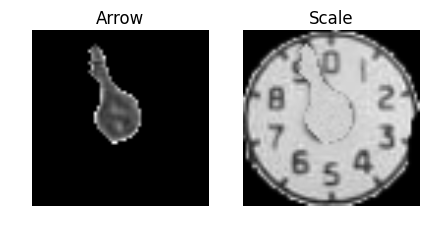

Finished generating training data for 0
Finished generating training data for 1
Finished generating training data for 2
Finished generating training data for 3
Finished generating training data for 4
Finished generating training data for 5
Finished generating training data for 6
Finished generating training data for 7
Finished generating training data for 8
Finished generating training data for 9


In [100]:
# Generate training data set
arrow, scale = separate_arrow_scale(data_gray, overlap_segmentation, 1)
arrow = rotate(arrow, -18)

number = 0
train_x = np.zeros((len(np.arange(0., 360., 0.1)), arrow.shape[0], arrow.shape[1]))
train_y = np.zeros(len(np.arange(0., 360., 0.1)))

for i, deg in enumerate(np.arange(0., 360., 0.1)):
    temp_scale = np.copy(scale)
    arrow_rotated = rotate(arrow, -deg)
    temp_scale[arrow_rotated > 0.] = arrow_rotated[arrow_rotated > 0.]
    if deg != 0. and (deg % 36.) == 0:
        number += 1
        print "Finished generating training data for " + str(number-1)
    train_x[i] = temp_scale
    train_y[i] = number
print "Finished generating training data for " + str(number)

In [101]:
# Apply HOG
fd, hog_img = hog(train_x[0], orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=True)
train_x_hog = np.zeros((len(train_x), len(fd)))
for i, temp_img in enumerate(train_x):
    train_x_hog[i] = hog(temp_img, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=False)

In [102]:
# Shuffle train test indices
idx_array = np.arange(0, len(train_x_hog))
random_train_idx = np.random.choice(idx_array, int(0.8 * len(idx_array)), replace=False)
random_test_idx = np.delete(idx_array, random_train_idx)

# train test split
random_train_x_hog = train_x_hog[random_train_idx]
random_train_y = train_y[random_train_idx]
random_test_x_hog = train_x_hog[random_test_idx]
random_test_y = train_y[random_test_idx]

# train test using SVM
svc = SVC()
svc.fit(random_train_x_hog, random_train_y)
pred_y = svc.predict(random_test_x_hog)

In [103]:
true_counter = 0.
for temp_pred, temp_true in zip(pred_y, random_test_y):
    if temp_pred == temp_true:
        true_counter += 1.
        
print "The accuracy of the SVM classifier is:", true_counter / float(len(pred_y))

The accuracy of the SVM classifier is: 0.976388888889
